**Author:**

Haolong Li (haolong.li@epfl.ch) (352680)

Zhibo Zhao (zhibo.zhao@epfl.ch) (350593)

# Project Outline

In this project we created a coin detection model. For an image containing mutiple coins of different types and values, the model first segments the image to obtain subfigures of separate coins, then each coin figure is fed to a single coin classification model for classification. We finally integrate the results from the subfigures from one image to get the detection result of the image.

## Segmentation
In general this step contains:
- Thresholding;
- Applying Mathematical Morphology;
- Detecting contours from the previous result;
- Identifying circualr contour shapes and append to the result.
  
There are 3 kinds of images: neutral, noisy, hand. For each kind of image, we try 2 different threholding + morphology strategies:
- **neutral bg + rgb thresholding**: 
  - Thresholding: lower bound (rgb) = 0, 0, 0; upper bound (rgb) = 150, 175, 175; 
  - Apply 2 closings (kernel size = 25\*25, 30\*30)
- **noisy bg + rgb thresholding**:
  - Thresholding: lower bound (rgb) = 0, 0, 0; upper bound (rgb) = 185, 180, 160; 
  - Apply 1 closing (kernel size = 11\*11)
- **hand bg + rgb thresholding**:
  - Thresholding: lower bound (rgb) = 0, 0, 0; upper bound (rgb) = 175, 175, 150; 
  - Apply 2 closings (kernel size = 30\*30, 35\*35)
- **adaptive thresholding**
  - Convert image to gray scale;
  - Apply Gaussian blurring (kernel size = 11*11)
  - Apply adaptive thresholding (see params in code)
  - Apply closing:
    - neutral bg: kernel size = 11;
    - noisy bg: kernel size = 20;
    - hand bg: kernel size = 9.

After applying thresholding + morphology, we proceed to the contour stage.
For the contours identfied, we filter out those who size deviates far away from its min enclosing circle's size to ensure we get circular shapes.

In implementation, since we don't know which kind of background the image is, we apply all the above 6 methods, and take the one with the most coins detected.

## Feature Extraction
As described above, for each image containing multiple images, we end up with many subfigures of separate coins, each subfigure containing only one coin. They are supposed to be [x, y, 3] arrays. Each array is then fed to our classifier to identify the coin.

## Classification
We train a model based the resnet pretrained model (on the image 1k dataset) in order to classify **single** coins.

**NOTE:** The training pipeline is not contained in this notebook because it's not possible to upload the whole training data to Moodle. We will however provide the `training.ipynb` in a separate file for the sake of integrity. For the model in this notebook, we will load the model weights from our training pipeline directly.

### Training Data Labeling
We used the labelImg package to label each coin and its position in the image. For each image, it ends up with a .xml file describing all the coins (class, position) in the image.

### Pretrained Model
We used `model = models.resnet50(weights='IMAGENET1K_V2')` as the pretrained model.

### Training
We split the labeled data into training set and validation set (size ratio = 9:1) and train 25 epochs. After each epoch, we calculate the CrossEntropyLoss on the validation set, and preserve the model with the least validation loss.

In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from typing import Callable
from datetime import datetime
import torchvision.models as models
import json
import torch
import pandas as pd
import torchvision.transforms as transforms
from PIL import Image

In [2]:
# thresholding + morphological operation + contour detection
def rgb_thresh(img, type):
    # neutral bg
    lower_bound = np.array([0, 0, 0]) 
    upper_bound = np.array([150, 175, 175]) 
    if type == 'noisy':
        upper_bound = np.array([185, 180, 160]) 
    if type == 'hand':
        upper_bound = np.array([175, 175, 150]) 
    thresh = cv2.inRange(img, lower_bound, upper_bound)
    return thresh

def process_image(image_path, type='neutral', method='adaptive'):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return
    
    # convert to rgb to work with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if method == 'rgb':
        # apply rgb thresholding
        thresh = rgb_thresh(image_rgb, type)
        # apply closing operation
        if type == 'neutral':
            kernel_1 = np.ones((25, 25), np.uint8)
            kernel_2 = np.ones((30, 30), np.uint8)
        elif type == 'noisy':
            kernel_1 = np.ones((11, 11), np.uint8)
            kernel_2 = np.ones((1, 1), np.uint8)
        elif type == 'hand':
            kernel_1 = np.ones((30, 30), np.uint8)
            kernel_2 = np.ones((35, 35), np.uint8)
        closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_1)
        closing = cv2.morphologyEx(closing, cv2.MORPH_CLOSE, kernel_2)
        
    elif method == 'adaptive':
        # applying gaussian blurring
        gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
        gray_image = cv2.GaussianBlur(gray_image, (11, 11), 0)
        # applying adaptive thresholding
        adaptive_thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                                cv2.THRESH_BINARY_INV, 11, 2)
        thresh = adaptive_thresh

        # apply closing operation
        kernel_adaptive = np.ones((11, 11), np.uint8)
        if type == 'hand':
            kernel_adaptive = np.ones((20, 20), np.uint8)
        elif type == 'noisy':
            kernel_adaptive = np.ones((9, 9), np.uint8)
        closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_adaptive)
        

    # calculate contours
    contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    coin_images = []
    for _, contour in enumerate(contours):
        # calculate the area of the contour and the area of the minimum enclosing circle
        area = cv2.contourArea(contour)
        (x, y), radius = cv2.minEnclosingCircle(contour)
        circle_area = np.pi * (radius ** 2)
        # check if the contour is approximately circular
        if abs(1 - (area / circle_area)) < 0.2:  
            x, y, w, h = cv2.boundingRect(contour)
            coin_image = image_rgb[y:y+h, x:x+w]
            coin_images.append(coin_image)

            # # show the coin image, for debugging
            # plt.figure()
            # plt.imshow(coin_image)
            # plt.title(f'Coin {len(coin_images)}')
            # plt.xticks([]), plt.yticks([])

    # # plot threshold image, contour image, for debugging
    # plt.figure(figsize=(12,8))
    # for i in range(4):
    #     plt.subplot(2, 3, i+1)
    #     plt.imshow(images[i])
    #     plt.title(titles[i])
    #     plt.xticks([]), plt.yticks([])

    # plt.show()

    return coin_images


In [3]:
# Load the model

with open(os.path.join('model', 'label_to_index.json'), 'r') as f:
    label_to_index = json.load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(weights='IMAGENET1K_V2')
num_classes = len(label_to_index)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(os.path.join('model','best_model.pth')))
model = model.to(device)

In [4]:
# The pred function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict_image(image_array, model=model, transform=transform, device=device):
    
    model.eval() 
    image = Image.fromarray(np.uint8(image_array)).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        top_prob, top_catid = torch.topk(probabilities, 1)

    index_to_label = {v: k for k, v in label_to_index.items()}

    return index_to_label[top_catid.item()], top_prob.item()


Predicted class: 1CHF, Probability: 0.9763496518135071


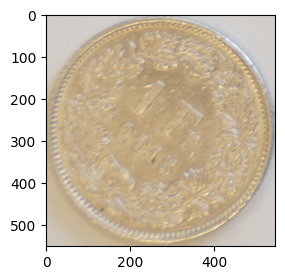

In [8]:
# Test the model
# Not needed for re-running

# image_path = os.path.join("data", "train", "L1010287.JPG")
# coins = process_image(image_path, type='neutral', method='adaptive')
# sample = coins[1]
# plt.figure(figsize=(3, 3))
# plt.imshow(sample)
# # 示例推理
# predicted_class, probability = predict_image(sample, model, transform, device)
# print(f"Predicted class: {predicted_class}, Probability: {probability}")

In [55]:
# generate the test pred
result = pd.DataFrame(columns=['id','5CHF','2CHF','1CHF','0.5CHF','0.2CHF','0.1CHF','0.05CHF','2EUR','1EUR','0.5EUR','0.2EUR','0.1EUR','0.05EUR','0.02EUR','0.01EUR','OOD'])

types = ['neutral', 'noisy', 'hand']
methods = ['rgb', 'adaptive']

for jpg_file in os.listdir('data/test'):
    image_path = os.path.join('data', 'test', jpg_file)
    pred_coins = []
    most_coins = 0
    for type in types:
        for method in methods:
            coins = process_image(image_path, type=type, method=method)
            if len(coins) > most_coins:
                pred_coins = coins
                most_coins = len(coins)
    
    new_id = jpg_file.split('.')[0]
    result.loc[len(result)] = [new_id] + [0] * (len(result.columns) - 1)
    
    for coin in pred_coins:
        predicted_class, probability = predict_image(coin, model, transform, device)
        result.loc[result['id'] == new_id, predicted_class] += 1

result.to_csv('result.csv', index=False)